# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [615]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import progressbar

%matplotlib inline

import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
#nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger','stopwords'])

from sklearn.metrics import f1_score


In [334]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [335]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [336]:
df.value_counts()

article_id  title                                                              email                                   
1170.0      apache spark lab, part 1: basic concepts                           1588af175b283915f597fc4719cbb2c8621c4fc2    42
                                                                               363cb98a087e4a3eb6890fd1af2d418116f85ff8    41
1429.0      use deep learning for image classification                         2b6c0f514c2f2b04ad3c4583407dccd0810469ee    35
                                                                               77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    35
                                                                               c8afd6f4620184042cc48ca0eba9a657ac89e90e    25
                                                                                                                           ..
645.0       how to perform a logistic regression in r                          9557b7576159d6b7f61782d2e9a24afa2ed8b78e     

In [337]:
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

In [338]:
distribution = df['email'].value_counts()
distribution 

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
f5035acf16af3e79700393838fa1023ad38da668      1
81335c2e5917100a5cbdcc2bc0285fed6d685f6d      1
98d4864a24bc8f9915c8c8b5ebd3aa1eaa71cbaf      1
c87e297a1a99ae042be2015ff9056cf13195eefd      1
1f18e8aaccd6c8720180c3fe264c8aef5b00697f      1
Name: count, Length: 5148, dtype: int64

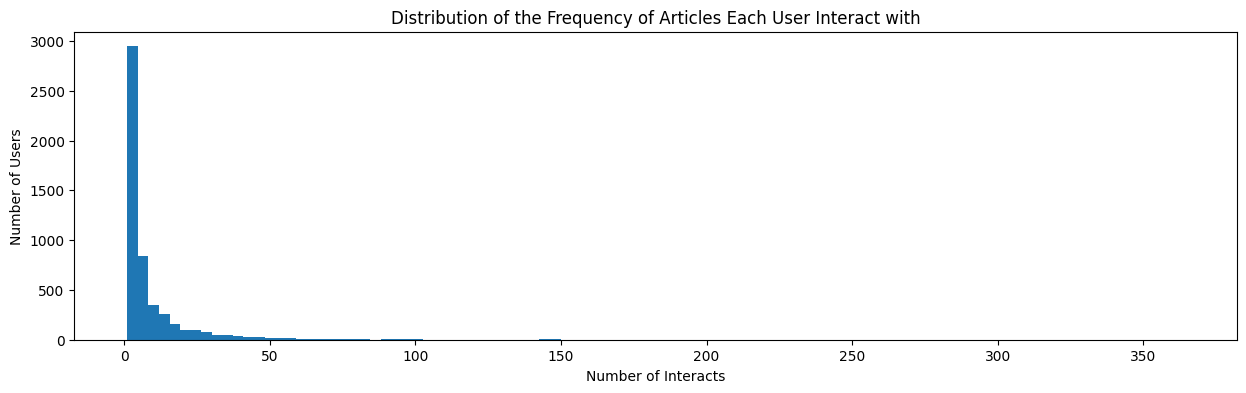

In [339]:
plt.figure(figsize = (15,7))
ax = plt.subplot()
plt.hist(distribution , bins = 100)
plt.xlabel('Number of Interacts')
plt.ylabel('Number of Users')
plt.title('Distribution of the Frequency of Articles Each User Interact with')
plt.show()


From the diagram, a lot of users just interacted once with the article.

In [340]:
distribution.median()

3.0

In [341]:
distribution.max()

364

In [342]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =  364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [343]:
# Find and explore duplicate articles
df_content['article_id'].duplicated().sum()

5

In [344]:
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [345]:
# Remove any rows that have the same article_id - only keep the first
df_content_1 = df_content.drop_duplicates(subset=['article_id'],keep='first')
df_content_1['article_id'].duplicated().sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [346]:
df_1 = df.groupby('article_id')['email'].count().reset_index()
df_1['interaction'] = df_1['email'].apply(lambda x : 1 if x >0 else 0)
df_1['interaction'].sum()


714

In [347]:
df_content['article_id'].nunique()

1051

In [348]:
df['email'].nunique()

5148

In [349]:
len(df)

45993

In [350]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` What is the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [351]:
df_1.sort_values(by = 'email',ascending=False).iloc[0,:]['article_id']

1429.0

In [352]:
df_1.sort_values(by = 'email',ascending=False).iloc[0,:]['email']

937.0

In [353]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [354]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [355]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Return the **n** top articles ordered with most interactions as the top.

In [356]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [357]:
df.groupby(['article_id','title'])['user_id'].count().reset_index().sort_values(by='user_id').loc[5,'title']

'timeseries data analysis of iot events by using jupyter notebook'

In [358]:
x = df.groupby(['article_id','title'])['user_id'].count().reset_index().sort_values(by='user_id',ascending=False).head(5)
x

,article_id,title,user_id
699,1429.0,use deep learning for image classification,937
625,1330.0,insights from new york car accident reports,927
701,1431.0,visualize car data with brunel,671
697,1427.0,"use xgboost, scikit-learn & ibm watson machine...",643
652,1364.0,predicting churn with the spss random tree alg...,627


In [359]:
list(x.index)

[699, 625, 701, 697, 652]

In [360]:
x['title'].values

array(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm'],
      dtype=object)

In [361]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_list = df.groupby(['article_id','title'])['user_id'].count().reset_index().sort_values(by='user_id',ascending=False).head(n)
    top_articles = list(top_list['title'].values)

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_list = df.groupby(['article_id','title'])['user_id'].count().reset_index().sort_values(by='user_id',ascending=False).head(n)
    top_articles = list(top_list['article_id'].values)
 
    return top_articles # Return the top article ids

In [362]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [363]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [364]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_2 = df.groupby(['user_id','article_id'])['title'].count().unstack().notnull()
    user_item = np.array(df_2.map(lambda x: 1 if x == True else 0))
    #user_item = np.where(df_2.isnull(), 0, 1)

    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [365]:
#user_item.to_pickle('user_item_matrix.p')

In [366]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[0] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [367]:
user_item_df = df.groupby(['user_id','article_id'])['title'].count().unstack().notnull()
user_item_df  = user_item_df.map(lambda x: 1 if x == True else 0)
user_item_df.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [368]:
user_item

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [369]:
user_item_df.index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
      dtype='int64', name='user_id', length=5149)

In [370]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''

    user_idx = np.where(user_item_df.index == user_id)[0][0] #return row position of user id

    # compute similarity of each user to the provided user
    similarity = np.dot(user_item[user_idx], np.transpose(user_item))

    # remove the own user's id
    # sort by similarity
    sorted_idx = np.argsort(similarity)[::-1][1:]

    # sort by similarity
    # create list of just the ids
    most_similar_users = user_item_df.iloc[sorted_idx].index.tolist()

       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [371]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [46, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [372]:
user_item

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [373]:
df.duplicated().sum()

12311

In [374]:
user_item_df

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [375]:
df.dtypes

article_id    float64
title          object
user_id         int64
dtype: object

In [376]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [465]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_ids = [float(x) for x in article_ids] #isiin takes 
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item_df=user_item_df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    user_idx = np.where(user_item_df.index == user_id)[0][0]
    article_ids = user_item_df.iloc[user_idx]
    
    article_ids = [str(ids) for ids in article_ids.loc[article_ids == 1].index]

    article_names= get_article_names(article_ids)
    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
   

    most_similar_users = find_similar_users(user_id)
    #n_users = len(most_similar_users)
    user_articles_ids = get_user_articles(user_id)[0]
    recs = np.array([])

    # # Create the progressbar
    # cnter = 0
    # bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    # bar.start()


    for similar_user in most_similar_users:

        if recs.shape[0] > m: 
            break
        else:
            similar_article_ids = get_user_articles(similar_user)[0]
            unseen_article_ids = np.setdiff1d(similar_article_ids,user_articles_ids,assume_unique=True)
            recs = np.append(recs,unseen_article_ids)

       
    recs = recs[:m]

    
    return recs # return your recommendations for this user_id    

In [466]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['timeseries data analysis of iot events by using jupyter notebook',
 'the 3 kinds of context: machine learning and the art of the frame',
 'using brunel in ipython/jupyter notebooks',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'using machine learning to predict parking difficulty',
 'higher-order logistic regression for large datasets',
 'experience iot with coursera',
 'graph-based machine learning',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)']

In [393]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [418]:
user_item

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [428]:
df.groupby(['user_id']).count()['article_id']

user_id
1       47
2        6
3       82
4       45
5        5
        ..
5145     6
5146     9
5147     1
5148     1
5149     1
Name: article_id, Length: 5149, dtype: int64

In [448]:
similar_user = find_similar_users(1)
x = df.groupby(['user_id']).count()['article_id']
#x[x['user_id'].isin(similar_user)]
x.loc[similar_user].tolist()



[45,
 364,
 363,
 160,
 158,
 145,
 144,
 63,
 61,
 67,
 147,
 145,
 69,
 147,
 85,
 83,
 148,
 58,
 80,
 79,
 102,
 101,
 170,
 60,
 169,
 60,
 132,
 45,
 78,
 95,
 131,
 52,
 137,
 84,
 59,
 95,
 82,
 97,
 94,
 51,
 44,
 136,
 76,
 82,
 80,
 43,
 92,
 79,
 75,
 47,
 102,
 76,
 49,
 48,
 104,
 42,
 84,
 68,
 83,
 62,
 94,
 43,
 79,
 60,
 66,
 56,
 57,
 140,
 24,
 61,
 65,
 59,
 49,
 57,
 75,
 41,
 142,
 39,
 103,
 58,
 29,
 22,
 46,
 44,
 48,
 77,
 40,
 48,
 101,
 89,
 57,
 91,
 63,
 22,
 68,
 38,
 41,
 81,
 79,
 53,
 52,
 34,
 15,
 50,
 89,
 114,
 72,
 50,
 52,
 69,
 51,
 76,
 74,
 23,
 39,
 58,
 27,
 21,
 38,
 91,
 67,
 22,
 25,
 70,
 78,
 55,
 20,
 68,
 80,
 35,
 50,
 26,
 24,
 59,
 51,
 116,
 53,
 82,
 34,
 22,
 84,
 67,
 49,
 35,
 40,
 20,
 31,
 48,
 82,
 42,
 34,
 48,
 82,
 58,
 20,
 33,
 42,
 29,
 35,
 11,
 12,
 28,
 29,
 28,
 38,
 28,
 38,
 16,
 48,
 26,
 62,
 72,
 21,
 41,
 16,
 73,
 46,
 14,
 38,
 51,
 56,
 22,
 47,
 27,
 52,
 35,
 30,
 32,
 23,
 30,
 34,
 46,
 25,
 28,
 23,

In [459]:
np.dot(user_item_df.loc[1], np.transpose(user_item_df.loc[similar_user])).shape

(5148,)

In [434]:
len(find_similar_users(1))

5148

In [454]:
len(df.groupby(['user_id']).count()['article_id'].loc[similar_user].tolist())

5148

In [469]:
def get_top_sorted_users(user_id, df=df, user_item_df=user_item_df):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    # sort user from teh most to least similar
    similar_user = find_similar_users(user_id)

    user_idx = np.where(user_item_df.index == user_id)[0][0] #return row position of user id
    similarity = np.dot(user_item_df.iloc[user_idx], np.transpose(user_item_df.loc[similar_user])).tolist()
   
    num_interactions = df.groupby(['user_id']).count()['article_id'].loc[similar_user].tolist()
    #num_interactions = num_interactions

    neighbors_df = pd.DataFrame({'neighbour_id':similar_user,
                                 'similarity':similarity,
                                 'num_interactions':num_interactions

    })
    neighbors_df = neighbors_df.sort_values(by = ['similarity','num_interactions'],ascending = False)

    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    top_sorted_users = get_top_sorted_users(user_id)['neighbour_id'].tolist()
    article_ids = get_user_articles(user_id)[0]
    recs = np.array([])
    

    for sorted_user in top_sorted_users:

        if recs.shape[0] > m:
            break
        else: 
            similar_article_ids = get_user_articles(sorted_user)[0]
            unseen_article_ids = np.setdiff1d(similar_article_ids,article_ids,assume_unique=True)
            recs = np.append(recs,unseen_article_ids)
        

    recs = recs[:m]
    rec_names = get_article_names(recs)[:m]
        


    
    return recs, rec_names

In [464]:
get_top_sorted_users(55, df=df, user_item_df=user_item_df)

,neighbour_id,similarity,num_interactions
0,3417,28,32
3,23,14,364
2,3782,14,363
1,203,14,160
4,4459,14,158
...,...,...,...
5139,2965,0,1
5141,2963,0,1
5144,2957,0,1
5146,2952,0,1


In [470]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0' '109.0' '125.0' '142.0' '164.0' '205.0' '302.0' '336.0' '362.0'
 '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'neural networks for beginners: popular types and applications', "a beginner's guide to variational methods", 'statistics for hackers', 'challenges in deep learning', 'accelerate your workflow with dsx', 'introduction to neural networks, advantages and applications', 'dsx: hybrid mode', 'tensorflow quick tips', 'learn tensorflow and deep learning together and now!']


`5.`  Test our dictionary against the solution.

In [477]:
get_top_sorted_users(1).iloc[0]

neighbour_id        3933
similarity            35
num_interactions      45
Name: 0, dtype: int64

In [478]:
get_top_sorted_users(131).iloc[9]

neighbour_id        242
similarity           25
num_interactions    148
Name: 9, dtype: int64

In [479]:
### Tests with a dictionary of results

user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [480]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, we would not have any information about the user liking or preference. Here, I would recommend to apply **Ranked- Based Recommendation** to make recommendation based on ratings. We can recommend article with top ratings or the the most interaction to the new users as a headstart.

Aslo, we can provide apply **Knowledge-Based Recommendation** on top of **Ranked-Based Recommendation** by asking the preference of new users at the start and then provide a list of popular recommendation to them.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the new user below.

In [485]:
ids = [str(x) for x in get_top_article_ids(10)]
ids

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [486]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = ids



In [487]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (TO BE UPDATED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.


In [489]:
df_content_1.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [500]:
df_content_1['doc_description'].isnull().sum()

3

In [491]:
def tokenize(texts):

    ## convert to string format 
    normalised_text = re.sub(r'[^a-zA-Z0-9]'," ",str(texts).lower())
   
    
    tokens = word_tokenize(normalised_text)
    tokens = [token for token in tokens if token not in stopwords.words("english")]

    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(token) for token in tokens]
    clean_tokens = [lemmatizer.lemmatize(w,pos='v') for w in lemmed]
    

    return clean_tokens

In [497]:
for message in df_content_1['doc_description'].iloc[:4]:
    print(message)
    print(tokenize(message),'\n')

Detect bad readings in real time using Python and Streaming Analytics.
['detect', 'bad', 'read', 'real', 'time', 'use', 'python', 'stream', 'analytics'] 

See the forest, see the trees. Here lies the challenge in both performing and presenting an analysis. As data scientists, analysts, and machine learning engineers faced with fulfilling business obj…
['see', 'forest', 'see', 'tree', 'lie', 'challenge', 'perform', 'present', 'analysis', 'data', 'scientist', 'analyst', 'machine', 'learn', 'engineer', 'face', 'fulfil', 'business', 'obj'] 

Here’s this week’s news in Data Science and Big Data.
['week', 'news', 'data', 'science', 'big', 'data'] 

Learn how distributed DBs solve the problem of scaling persistent storage, but introduce latency as data size increases and become I/O bound.
['learn', 'distribute', 'db', 'solve', 'problem', 'scale', 'persistent', 'storage', 'introduce', 'latency', 'data', 'size', 'increase', 'become', 'bind'] 



In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''
    

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [501]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [502]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [503]:
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [504]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

In [506]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In [510]:
total_var =np.sum(s**2)
var_exp_comp1_comp2_comp3 = s[0]**2 + s[1]**2 + s[3]**2
perc_exp = round(var_exp_comp1_comp2_comp3 /total_var*100, 2)
print("The total variance in the original matrix is {}.".format(total_var))
print("Ther percentage of variability captured by the first three components is {}%.".format(perc_exp))

The total variance in the original matrix is 33682.000000000015.
Ther percentage of variability captured by the first three components is 11.97%.


**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [523]:
s[:10]

array([55.34570373, 23.2486418 , 21.76002282, 20.65833406, 19.97088674,
       19.55694619, 19.16323422, 18.71975076, 18.34386147, 18.0639261 ])

In [518]:
for k in np.arange(10,700+10,20):
    print(k)
    s_new=s[:k]
    
    print(s_new)

10
[55.34570373 23.2486418  21.76002282 20.65833406 19.97088674 19.55694619
 19.16323422 18.71975076 18.34386147 18.0639261 ]
30
[55.34570373 23.2486418  21.76002282 20.65833406 19.97088674 19.55694619
 19.16323422 18.71975076 18.34386147 18.0639261  17.63776858 17.43354739
 17.43017327 17.09308763 16.76385291 16.46698708 16.45595124 16.30689489
 16.16660301 15.74440473 15.70388052 15.58789772 15.50133886 15.37460233
 15.22127891 15.04011109 14.94823648 14.77375293 14.67043322 14.60978961]
50
[55.34570373 23.2486418  21.76002282 20.65833406 19.97088674 19.55694619
 19.16323422 18.71975076 18.34386147 18.0639261  17.63776858 17.43354739
 17.43017327 17.09308763 16.76385291 16.46698708 16.45595124 16.30689489
 16.16660301 15.74440473 15.70388052 15.58789772 15.50133886 15.37460233
 15.22127891 15.04011109 14.94823648 14.77375293 14.67043322 14.60978961
 14.53120739 14.40257109 14.3073643  14.06545976 13.89956957 13.85762588
 13.78100837 13.63882891 13.60558296 13.57492151 13.51963093 13.

In [519]:
for k in np.arange(10,700+10,20):
    print(k)
    s_new=np.diag(s[:k])
    print(s_new)

10
[[55.34570373  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         23.2486418   0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         21.76002282  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         20.65833406  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         19.97088674  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         19.55694619
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  19.16323422  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         18.71975076  0.          0.        ]
 [ 0.          0.          0.          0.          0.

c:\Users\chyij\Documents\Data Science Portfolio\virtualenvs\venv_main\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


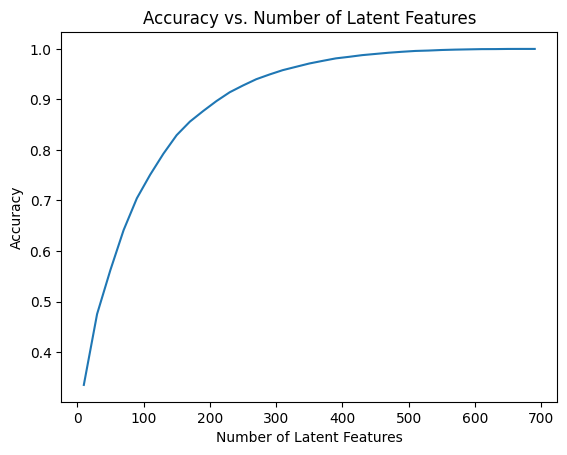

In [509]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [527]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [530]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [534]:
df_train.groupby(['user_id','article_id']).count()['title'].unstack()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4484,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [535]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_user_item(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_2 = df.groupby(['user_id','article_id'])['title'].count().unstack().notnull()
    user_item = df_2.map(lambda x: 1 if x == True else 0)
    #user_item = np.where(df_2.isnull(), 0, 1)

    
    return user_item # return the user_item matrix 

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item(df_train)
    user_item_test = create_user_item(df_test)

    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [546]:
len(user_item_train)

4487

In [545]:
len(user_item_test)

682

In [544]:
# 'How many users can we make predictions for in the test set?'
train_idx = user_item_train.index
user_item_test.index.isin(train_idx).sum()

20

In [547]:
#'How many users in the test set are we not able to make predictions for because of the cold start problem?'
len(user_item_test) - user_item_test.index.isin(train_idx).sum()

662

In [549]:
# 'How many articles can we make predictions for in the test set?'
train_arts = user_item_train.columns
user_item_test.columns.isin(train_arts).sum()

574

In [550]:
# 'How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(user_item_test.columns) - user_item_test.columns.isin(train_arts).sum()

0

In [551]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [575]:
len(user_item_train.columns)

714

In [576]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [567]:
# find the subset of users and articles that can be predicted
u_test = u_train[user_item_train.index.isin(test_idx),:]
vt_test = vt_train[:,user_item_train.columns.isin(test_arts)]
u_test.shape,vt_test.shape

((20, 4487), (714, 574))

In [587]:
# Obtain the subset of user and article that can be predicted
user_index = np.intersect1d(user_item_train.index,test_idx)
user_article = np.intersect1d(user_item_train.columns,test_arts)
user_item_test_pred = user_item_test.loc[user_index,user_article]

c:\Users\chyij\Documents\Data Science Portfolio\virtualenvs\venv_main\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\chyij\Documents\Data Science Portfolio\virtualenvs\venv_main\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\chyij\Documents\Data Science Portfolio\virtualenvs\venv_main\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over bot

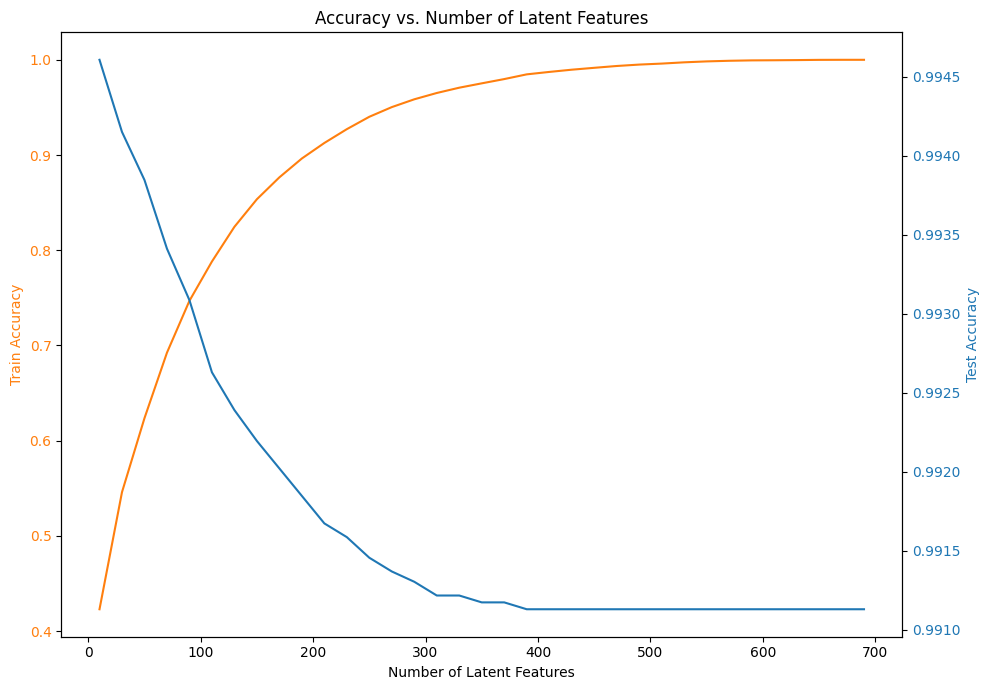

In [642]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

f1_train = []
f1_test = []

for k in num_latent_feats:
    # restructure with k latent features

    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]


    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_test_est = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_pred, user_item_test_est)

    #sum_square_errs = np.sum(np.sum((user_movie_subset - pred_ratings)**2))
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))

    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

    # Have to flatten the array to 1-d as sklearn expects the target variable to be a 1-d array
    f1_train.append(f1_score(np.array(user_item_train).flatten(),user_item_train_est.flatten(),average = 'macro'))
    f1_test.append(f1_score(np.array(user_item_test_pred).flatten(),user_item_test_est.flatten(),average='macro'))


fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:orange'
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Train Accuracy',color = color)
ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0],color = color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax1.set_title('Accuracy vs. Number of Latent Features')

ax2 = ax1.twinx() #instantiate a second axes that shares the same x axis

color = 'tab:blue'
ax2.set_ylabel('Test Accuracy',color = color)
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0],color = color)
ax2.tick_params(axis='y',labelcolor = color)

fig.tight_layout()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Tne train accuracy increases as the number of latent features increases, while the test accuracy decreases while the number of latent features increases. The result is misleading due to class imablance where there is more number of zero than one in the matrix.

Thus, F1 score might be a btter metric to validate the result.

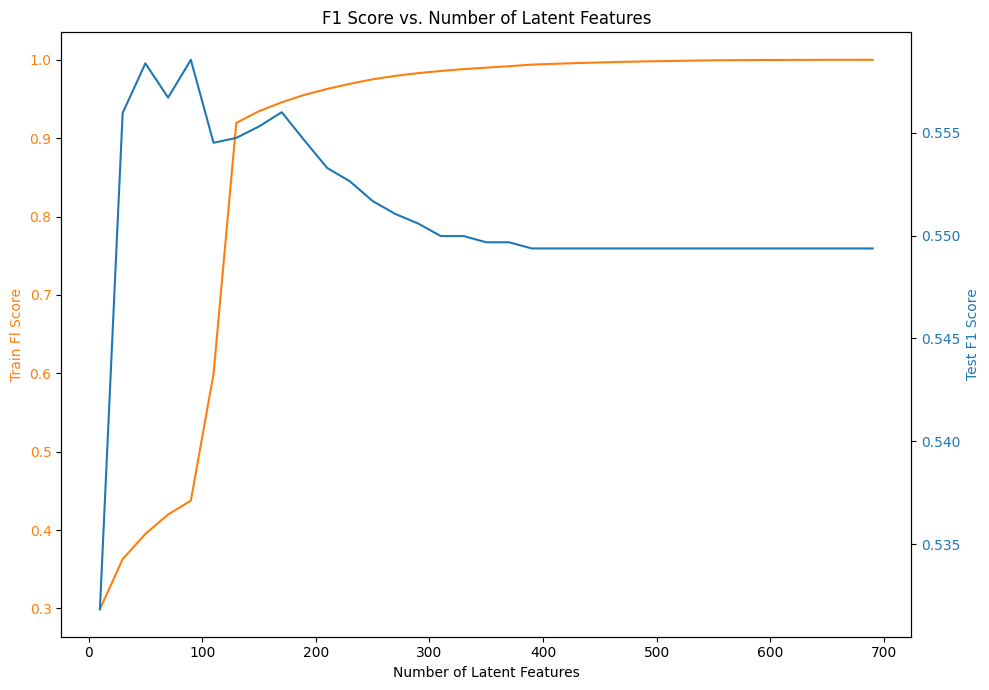

In [650]:
fig, ax3 = plt.subplots(figsize=(10,7))

color = 'tab:orange'
ax3.set_xlabel('Number of Latent Features')
ax3.set_ylabel('Train Fl Score',color = color)
ax3.plot(num_latent_feats,f1_train, color = color)
ax3.tick_params(axis = 'y', labelcolor = color)
ax3.set_title('F1 Score vs. Number of Latent Features')

ax4 = ax3.twinx() #instantiate a second axes that shares the same x axis

color = 'tab:blue'
ax4.set_ylabel('Test F1 Score',color = color)
ax4.plot(num_latent_feats, f1_test,color = color)
ax4.tick_params(axis='y',labelcolor = color)

fig.tight_layout()
plt.show()

From the F1 plot above, we can deduce that the train F1 score increases when the number of latent features increase. However, the test F1 score increases to a certain extent when the number of latent features increases. This is the sign of overfitting which causes the performance on test dataset to decrease. The best number of latent features would be around 100.

In order to access tHE performance of remmendation system, we can:
- Deploy the recomendation system above and monitor the performance. If the interactions rate increases after the deployment, we can know that the recommender is working effectively.

- Create a feedback system for the users to rate on the recomended articles to see if they 'like' or 'dislike' them.

- Conduct A/B tsting based on the interaction rate before and after the deployement of recommendation system to see if there is any significant differences.


In [ ]:
# download as .html file
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])